**Setting Up the Environment and Installing Dependencies**

In [1]:
print("???")

???


In [ ]:
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode
!pip install matplotlib>=3.3.2

## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

#exit()

In [5]:
BRANCH = 'main'
!sudo apt install python3-git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

In [7]:
!git clone https://github.com/NVIDIA/NeMo.git

#!apt-get update && apt-get install -y libsndfile1 ffmpeg
!cd NeMo;./reinstall.sh
!pip3 install -r ./NeMo/tools/speech_data_explorer/requirements.txt

In [3]:
import nemo
import nemo.collections.asr as nemo_asr

In [4]:
import glob
import os
import subprocess
import tarfile
import wget
import pandas as pd
import json
import re
import librosa

In [5]:
os.getcwd()

'/workspace/nemo'

In [6]:
path = r"/workspace/cv-corpus-19.0-2024-09-13"
os.chdir(path)
print("Files in the directory:", os.listdir())

Files in the directory: ['3.3.2', 'checkpoints', 'configs', 'dev_manifest.json', 'DL_Project_Local.ipynb', 'Dockerfile', 'ffmpeg-git-essentials.zip', 'ffmpeg-release-essentials.zip', 'hy-AM', 'lightning_logs', 'logs', 'nemo', 'train_manifest.json']


In [7]:
import torch
torch.cuda.is_available()

True

In [8]:
path = r"/workspace/cv-corpus-19.0-2024-09-13"

clips_folder = os.path.join(path, "hy-AM", "clips")
tsv_file = os.path.join(path, "hy-AM", "train.tsv")
manifest_file = os.path.join(path, "train_manifest.json")  # Assuming it's directly in the path folder
durations_tsv = os.path.join(path, "hy-AM", "clip_durations.tsv")

print("Clips folder:", clips_folder)
print("TSV file:", tsv_file)
print("Manifest file:", manifest_file)
print("Durations TSV:", durations_tsv)


Clips folder: /workspace/cv-corpus-19.0-2024-09-13/hy-AM/clips
TSV file: /workspace/cv-corpus-19.0-2024-09-13/hy-AM/train.tsv
Manifest file: /workspace/cv-corpus-19.0-2024-09-13/train_manifest.json
Durations TSV: /workspace/cv-corpus-19.0-2024-09-13/hy-AM/clip_durations.tsv


In [ ]:
import subprocess

# Define paths
clips_folder = r"/workspace/cv-corpus-19.0-2024-09-13/hy-AM/clips"
clips_wav_folder = r"/workspace/cv-corpus-19.0-2024-09-13/hy-AM/clips_wav"

if not os.path.exists(clips_wav_folder):
    os.makedirs(clips_wav_folder)

mp3_files = [f for f in os.listdir(clips_folder) if f.endswith(".mp3")]

for mp3_file in mp3_files:
    mp3_path = os.path.join(clips_folder, mp3_file)
    wav_filename = os.path.splitext(mp3_file)[0] + ".wav"
    wav_path = os.path.join(clips_wav_folder, wav_filename)

    ffmpeg_command = [ffmpeg_path, "-i", mp3_path, wav_path]
    
    try:
        subprocess.run(ffmpeg_command, check=True)
        print(f"Converted: {mp3_file} to {wav_filename}")
    except subprocess.CalledProcessError as e:
        print(f"Error converting {mp3_file}: {e}")

print("Conversion completed.")


In [30]:
df = pd.read_csv(tsv_file, sep='\t')
durations_df = pd.read_csv(durations_tsv, sep='\t')

# Create a dictionary to map file names to durations
duration_map = dict(zip(durations_df['clip'], durations_df['duration[ms]']))

# Function to preprocess text: remove punctuation and convert to lowercase
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# Function to create the manifest file
def create_manifest(df, clips_folder, output_file, duration_map):
    with open(output_file, 'w', encoding='utf-8') as fout:
        for index, row in df.iterrows():
            # Convert the .mp3 path to .wav
            wav_file_name = row['path'].replace(".mp3", ".wav")  # Replace mp3 with wav
            audio_file_path = os.path.join('/workspace/cv-corpus-19.0-2024-09-13/hy-AM/clips_wav',wav_file_name)  # Full path to the .wav file

            file_name = row['path'].split('/')[-1]  # Extract the original .mp3 file name

            # Retrieve the duration from the duration_map and convert from milliseconds to seconds
            duration_ms = duration_map.get(file_name, None)
            duration_sec = duration_ms / 1000 if duration_ms is not None else None

            # Preprocess the transcription text
            cleaned_text = preprocess_text(row['sentence'])  # Apply preprocessing

            # Create a dictionary for each audio sample
            entry = {
                "audio_filepath": audio_file_path,  # Use the .wav file path
                "text": cleaned_text,  # Preprocessed transcription text
                "duration": duration_sec  # Duration in seconds
            }
            fout.write(json.dumps(entry, ensure_ascii=True) + '\n')  # Write the entry to the manifest file
            #else:
               # print(f"Audio file not found: {audio_file_path}")  # Debugging: If file is not found

# Call the function to create the manifest with .wav paths
create_manifest(df, clips_folder, manifest_file, duration_map)

print(f"Manifest file {manifest_file} created successfully with .wav file paths!")


Manifest file /workspace/cv-corpus-19.0-2024-09-13/train_manifest.json created successfully with .wav file paths!


In [31]:
durations_df = pd.read_csv(durations_tsv, sep='\t')
print(durations_df.head())
print(durations_df.columns)

                              clip  duration[ms]
0  common_voice_hy-AM_39986870.mp3          5328
1  common_voice_hy-AM_40004342.mp3          8208
2  common_voice_hy-AM_27605078.mp3          3528
3  common_voice_hy-AM_39986437.mp3          4500
4  common_voice_hy-AM_40086101.mp3          3420
Index(['clip', 'duration[ms]'], dtype='object')


the contents of the dataframe

In [32]:
print(df.head(1))

                                           client_id  \
0  93fa435db2b9e077af647c9f846d8b6031bcb1f6cd731e...   

                              path  \
0  common_voice_hy-AM_26466425.mp3   

                                         sentence_id  \
0  014e1b24fd333a70a23e79c20cd4822a843711386f585a...   

                                 sentence  sentence_domain  up_votes  \
0  Հորիզոնին երևում են մերկ ծառեր և տներ։              NaN         2   

   down_votes       age          gender accents  variant locale  segment  
0           0  twenties  male_masculine     NaN      NaN  hy-AM      NaN  


In [33]:
with open('train_manifest.json', 'r') as f:
    for i in range(5):
        print(f.readline())

{"audio_filepath": "/workspace/cv-corpus-19.0-2024-09-13/hy-AM/clips_wav/common_voice_hy-AM_26466425.wav", "text": "\u0570\u0578\u0580\u056b\u0566\u0578\u0576\u056b\u0576 \u0565\u0580\u0587\u0578\u0582\u0574 \u0565\u0576 \u0574\u0565\u0580\u056f \u056e\u0561\u057c\u0565\u0580 \u0587 \u057f\u0576\u0565\u0580", "duration": 5.832}

{"audio_filepath": "/workspace/cv-corpus-19.0-2024-09-13/hy-AM/clips_wav/common_voice_hy-AM_26466426.wav", "text": "\u0569\u0583\u0565\u0580\u0568 \u057f\u0561\u0580\u0561\u056e\u057e\u0561\u056e \u0565\u0576 \u057f\u0578\u0582\u0576\u0564\u0580\u0561\u0575\u0578\u0582\u0574 \u0573\u0561\u0570\u056b\u0573\u0576\u0565\u0580\u056b \u057e\u0580\u0561 \u0583\u0577\u0561\u057f\u0565\u0580\u0587 \u0561\u0576\u057f\u0561\u057c\u0576\u0565\u0580\u0578\u0582\u0574 \u0562\u0561\u0580\u0571\u0580 \u056c\u0565\u057c\u0576\u0565\u0580\u0578\u0582\u0574", "duration": 8.352}

{"audio_filepath": "/workspace/cv-corpus-19.0-2024-09-13/hy-AM/clips_wav/common_voice_hy-AM_26466427.

In [27]:
import librosa
import IPython.display as ipd

# Load and listen to the audio file
example_file = 'hy-AM/clips_wav/common_voice_hy-AM_40948357.wav'

audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)


In [33]:
print(f"Audio Shape: {audio.shape}")
duration = len(audio) / sample_rate
print(f"Audio Duration: {duration:.2f} seconds")
print(f"Sample Rate: {sample_rate} Hz")

mean_amplitude = np.mean(audio)
max_amplitude = np.max(audio)
min_amplitude = np.min(audio)

print(f"Mean Amplitude: {mean_amplitude:.4f}")
print(f"Max Amplitude: {max_amplitude:.4f}")
print(f"Min Amplitude: {min_amplitude:.4f}")

Audio Shape: (139709,)
Audio Duration: 6.34 seconds
Sample Rate: 22050 Hz
Mean Amplitude: 0.0000
Max Amplitude: 0.9291
Min Amplitude: -0.8288


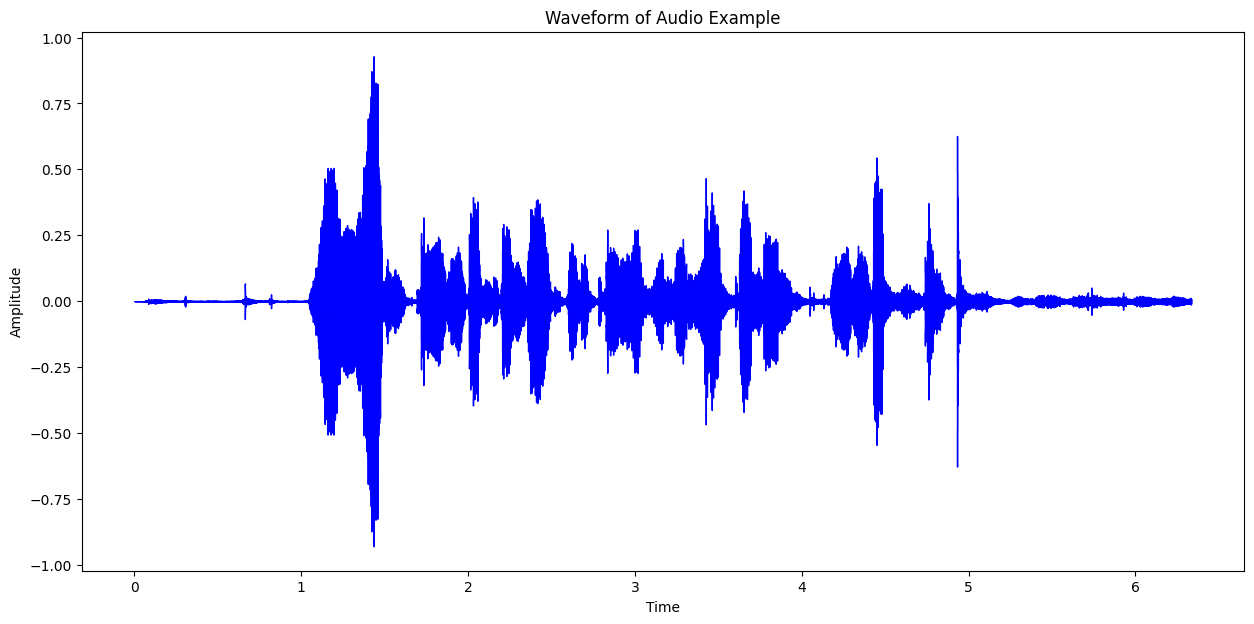

In [32]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt
import numpy as np 

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveshow(audio, color='blue')

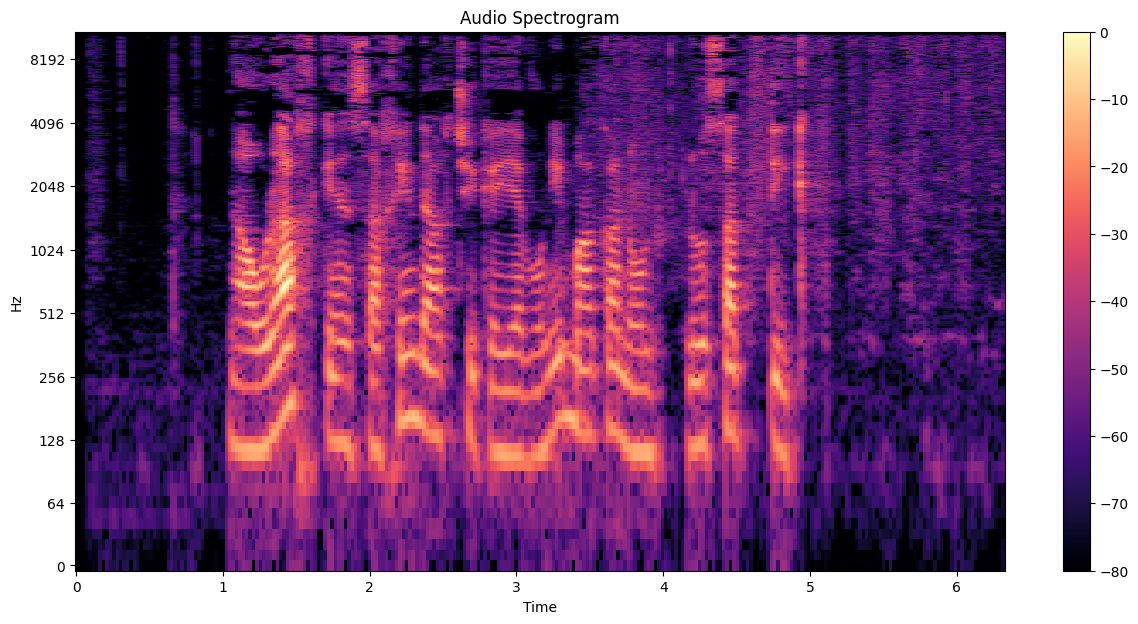

In [36]:

import numpy as np

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

In [37]:
import nemo.collections.asr as nemo_asr

quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2024-11-20 19:44:38 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2024-11-20 19:44:38 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2024-11-20 19:44:38 common:924] Instantiating model from pre-trained checkpoint
[NeMo I 2024-11-20 19:44:40 features:289] PADDING: 16
[NeMo I 2024-11-20 19:44:41 save_restore_connector:249] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


In [9]:
########Config File ###########
try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML
config_path = './configs/config.yaml'

if not os.path.exists(config_path):
    # Grab the config we'll use in this example
    BRANCH = 'main'
    !mkdir configs
    !wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml

yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)

print(params)

{'name': 'QuartzNet15x5', 'sample_rate': 16000, 'repeat': 1, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'model': {'train_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'trim_silence': True, 'max_duration': 16.7, 'shuffle': True, 'num_workers': 8, 'pin_memory': True, 'is_tarred': False, 'tarred_audio_filepaths': None, 'shuffle_n': 2048, 'bucketing_strategy': 'synced_randomized', 'bucketing_batch_size': None}, 'validation_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'shuffle': False, 'num_work

In [10]:
! cat ./configs/config.yaml

name: &name "QuartzNet15x5"
sample_rate: &sample_rate 16000
repeat: &repeat 1
dropout: &dropout 0.0
separable: &separable true
labels: &labels [" ", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
         "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "'"]

model:
  train_ds:
    manifest_filepath: ???
    sample_rate: 16000
    labels: *labels
    batch_size: 32
    trim_silence: True
    max_duration: 16.7
    shuffle: True
    num_workers: 8
    pin_memory: true
    # tarred datasets
    is_tarred: false
    tarred_audio_filepaths: null
    shuffle_n: 2048
    # bucketing params
    bucketing_strategy: "synced_randomized"
    bucketing_batch_size: null

  validation_ds:
    manifest_filepath: ???
    sample_rate: 16000
    labels: *labels
    batch_size: 32
    shuffle: False
    num_workers: 8
    pin_memory: true

  preprocessor:
    _target_: nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor
    normalize: "per_feature"
    window_

In [18]:
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2024-11-22 20:18:06 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo to /root/.cache/torch/NeMo/NeMo_1.23.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
100% [........................................................................] 71087043 / 71087043[NeMo I 2024-11-22 20:18:26 common:924] Instantiating model from pre-trained checkpoint
[NeMo I 2024-11-22 20:18:28 features:289] PADDING: 16
[NeMo I 2024-11-22 20:18:30 save_restore_connector:249] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


In [11]:
armenian_vocabulary = [
    ' ', 'ա', 'բ', 'գ', 'դ', 'ե', 'զ', 'է', 'ը', 'թ', 'ժ', 'ի', 'լ', 'խ',
    'ծ', 'կ', 'հ', 'ձ', 'ղ', 'ճ', 'մ', 'յ', 'ն', 'շ', 'ո', 'չ', 'պ', 'ջ',
    'ռ', 'ս', 'վ', 'տ', 'ր', 'ց', 'ւ', 'փ', 'ք','և', 'օ', 'ֆ'
]

In [12]:
2

2

In [13]:
params["labels"] = armenian_vocabulary
params["model"]["train_ds"]["labels"] = armenian_vocabulary
params["model"]["validation_ds"]["labels"] = armenian_vocabulary
params["model"]["decoder"]["vocabulary"] = armenian_vocabulary
params["model"]["decoder"]["num_classes"] = len(armenian_vocabulary)
print(params)

{'name': 'QuartzNet15x5', 'sample_rate': 16000, 'repeat': 1, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'ա', 'բ', 'գ', 'դ', 'ե', 'զ', 'է', 'ը', 'թ', 'ժ', 'ի', 'լ', 'խ', 'ծ', 'կ', 'հ', 'ձ', 'ղ', 'ճ', 'մ', 'յ', 'ն', 'շ', 'ո', 'չ', 'պ', 'ջ', 'ռ', 'ս', 'վ', 'տ', 'ր', 'ց', 'ւ', 'փ', 'ք', 'և', 'օ', 'ֆ'], 'model': {'train_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'ա', 'բ', 'գ', 'դ', 'ե', 'զ', 'է', 'ը', 'թ', 'ժ', 'ի', 'լ', 'խ', 'ծ', 'կ', 'հ', 'ձ', 'ղ', 'ճ', 'մ', 'յ', 'ն', 'շ', 'ո', 'չ', 'պ', 'ջ', 'ռ', 'ս', 'վ', 'տ', 'ր', 'ց', 'ւ', 'փ', 'ք', 'և', 'օ', 'ֆ'], 'batch_size': 32, 'trim_silence': True, 'max_duration': 16.7, 'shuffle': True, 'num_workers': 8, 'pin_memory': True, 'is_tarred': False, 'tarred_audio_filepaths': None, 'shuffle_n': 2048, 'bucketing_strategy': 'synced_randomized', 'bucketing_batch_size': None}, 'validation_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'ա', 'բ', 'գ', 'դ', 'ե', 'զ', 'է', 'ը', 'թ', 'ժ', 'ի', 'լ', '

In [14]:
params["model"]["train_ds"]["num_workers"] = 10
params["model"]["validation_ds"]["num_workers"] = 10

In [43]:
# Define the paths for the dev set clips folder and the TSV files
clips_folder = "/workspace/cv-corpus-19.0-2024-09-13/hy-AM/clips"
dev_tsv_file = "/workspace/cv-corpus-19.0-2024-09-13/hy-AM/dev.tsv"
dev_durations_tsv = "/workspace/cv-corpus-19.0-2024-09-13/hy-AM/clip_durations.tsv"
dev_manifest_file = "/workspace/cv-corpus-19.0-2024-09-13/dev_manifest.json"

# Load the dev set TSV and the clip durations TSV
df_dev = pd.read_csv(dev_tsv_file, sep='\t')
durations_df = pd.read_csv(dev_durations_tsv, sep='\t')

# Create a dictionary to map file names to durations
duration_map = dict(zip(durations_df['clip'], durations_df['duration[ms]']))

# Call the existing create_manifest() function to create the dev (validation) manifest
create_manifest(df_dev, clips_folder, dev_manifest_file, duration_map)

print(f"Dev manifest file {dev_manifest_file} created successfully!")


Dev manifest file /workspace/cv-corpus-19.0-2024-09-13/dev_manifest.json created successfully!


In [33]:
with open("/workspace/cv-corpus-19.0-2024-09-13/dev_manifest.json", 'r') as f:
    for _ in range(5):
        print(f.readline())

{"audio_filepath": "/workspace/cv-corpus-19.0-2024-09-13/hy-AM/clips_wav/common_voice_hy-AM_31108224.wav", "text": "\u057f\u0578\u057d\u0561\u056d\u0576 \u0578\u0582\u0576\u056b \u0570\u0561\u0574\u0561\u0579\u0561\u0583 \u056f\u0561\u0580\u056e\u0580\u0578\u0582\u0569\u0575\u0578\u0582\u0576 \u0564\u056b\u0574\u0561\u0581\u056f\u0578\u0582\u0576 \u0567 \u056f\u0578\u057f\u0580\u057e\u0561\u056e\u0584\u0576\u0565\u0580\u056b \u0587 \u0573\u0565\u0572\u0584\u057e\u0561\u056e\u0584\u0565\u0580\u056b \u0576\u056f\u0561\u057f\u0574\u0561\u0574\u0562", "duration": 7.596}

{"audio_filepath": "/workspace/cv-corpus-19.0-2024-09-13/hy-AM/clips_wav/common_voice_hy-AM_31108225.wav", "text": "\u056b\u0576\u0571 \u0563\u0580\u0561\u057e\u0578\u0582\u0574 \u0565\u0576 \u057f\u0572\u0561\u0574\u0561\u0580\u0564\u056b\u056f \u0578\u0582 \u0576\u0561\u0587 \u056f\u0561\u0576\u0561\u0575\u0584", "duration": 4.536}

{"audio_filepath": "/workspace/cv-corpus-19.0-2024-09-13/hy-AM/clips_wav/common_voice_hy-

In [15]:
train_manifest = "/workspace/cv-corpus-19.0-2024-09-13/train_manifest.json"
dev_manifest = "/workspace/cv-corpus-19.0-2024-09-13/dev_manifest.json"

In [16]:
params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = dev_manifest

In [ ]:
############### Hyperparameter Tuning ###################

import random
import torch
import nemo.collections.asr as nemo_asr
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

hyperparams = {
    'learning_rate': [0.001, 0.002, 0.005, 0.01],
    'batch_size': [16, 32],
    'optimizer': ['Adam', 'Novograd', 'AdamW'],
    'weight_decay': [0, 0.0001, 0.001],
    'lr_scheduler': ['CosineAnnealing', 'StepLR'],
}

def get_random_hyperparams(hyperparams, num_samples=5):
    keys = list(hyperparams.keys())
    sampled_params = []
    for _ in range(num_samples):
        params = {key: random.choice(hyperparams[key]) for key in keys}
        sampled_params.append(params)
    return sampled_params

random_samples = get_random_hyperparams(hyperparams, num_samples=5)  # Change num_samples as needed

random_samples

[{'learning_rate': 0.001,
  'batch_size': 32,
  'optimizer': 'AdamW',
  'weight_decay': 0,
  'lr_scheduler': 'StepLR'},
 {'learning_rate': 0.001,
  'batch_size': 32,
  'optimizer': 'Adam',
  'weight_decay': 0.001,
  'lr_scheduler': 'StepLR'},
 {'learning_rate': 0.002,
  'batch_size': 16,
  'optimizer': 'Novograd',
  'weight_decay': 0.0001,
  'lr_scheduler': 'CosineAnnealing'},
 {'learning_rate': 0.001,
  'batch_size': 32,
  'optimizer': 'AdamW',
  'weight_decay': 0.001,
  'lr_scheduler': 'CosineAnnealing'},
 {'learning_rate': 0.001,
  'batch_size': 32,
  'optimizer': 'Novograd',
  'weight_decay': 0.0001,
  'lr_scheduler': 'StepLR'}]

In [ ]:
from omegaconf import DictConfig
import copy
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

best_val_loss = float('inf')
best_config = None

for params_sample in random_samples:
    learning_rate = params_sample['learning_rate']
    batch_size = params_sample['batch_size']
    optimizer_name = params_sample['optimizer']
    weight_decay = params_sample['weight_decay']
    lr_scheduler = params_sample['lr_scheduler']

    updated_params = copy.deepcopy(params)
    updated_params["model"]['train_ds']['batch_size'] = batch_size
    updated_params["model"]['validation_ds']['batch_size'] = batch_size

    new_opt = {
        "name": optimizer_name.lower(),
        "lr": learning_rate,
        "weight_decay": weight_decay,
    }

    if lr_scheduler == 'CosineAnnealing':
        new_opt["sched"] = {
            "name": "CosineAnnealing"
        }
    elif lr_scheduler == 'StepLR':
        new_opt["sched"] = {
            "name": "StepLR",
            "step_size": 10,
            "gamma": 0.1,
        }

    logger = TensorBoardLogger(
        save_dir='/workspace/cv-corpus-19.0-2024-09-13/logs',
        name=f'lightning_logs_lr_{learning_rate}_bs_{batch_size}_opt_{optimizer_name}_wd_{weight_decay}_sched_{lr_scheduler}'
    )

    checkpoint_callback = ModelCheckpoint(
        dirpath='/workspace/cv-corpus-19.0-2024-09-13/checkpoints',
        filename=f'quartznet-best-{learning_rate}-{batch_size}-{optimizer_name}-{weight_decay}-{lr_scheduler}',
        monitor='val_loss',
        mode='min',
        save_top_k=1,
        save_weights_only=True
    )

    quartznet = nemo_asr.models.EncDecCTCModel(cfg=DictConfig(updated_params["model"]))
    quartznet.to('cuda')
    quartznet.setup_optimization(optim_config=DictConfig(new_opt))

    trainer = pl.Trainer(
        max_epochs=1,
        log_every_n_steps=10,
        logger=logger,
        callbacks=[checkpoint_callback],
        accelerator="gpu",
        devices=1,  # Ensures single GPU is used
        enable_progress_bar=True
    )

    trainer.fit(quartznet)

    # Retrieve val_loss directly from trainer metrics
    metrics = trainer.callback_metrics
    if 'val_loss' in metrics:
        val_loss = metrics['val_loss']

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_config = params_sample
            
    print("---------------------------------------------------------")
    print(f"Validation Loss for current run: {val_loss}")
    print(f"Validation Loss up to  current run: {best_val_loss}")        
    print("---------------------------------------------------------")

print(f"Best Hyperparameters: {best_config} with validation loss: {best_val_loss}")


[NeMo I 2024-11-22 21:33:12 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-11-22 21:33:12 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-11-22 21:33:14 collections:196] Dataset loaded with 6305 files totalling 9.09 hours
[NeMo I 2024-11-22 21:33:14 collections:197] 0 files were filtered totalling 0.00 hours


[NeMo W 2024-11-22 21:33:14 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      warnings.warn(_create_warning_msg(
    


[NeMo I 2024-11-22 21:33:14 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-11-22 21:33:14 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-11-22 21:33:14 collections:196] Dataset loaded with 4539 files totalling 6.84 hours
[NeMo I 2024-11-22 21:33:14 collections:197] 0 files were filtered totalling 0.00 hours
[NeMo I 2024-11-22 21:33:14 features:289] PADDING: 16


[NeMo W 2024-11-22 21:33:15 modelPT:612] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2024-11-22 21:33:15 modelPT:723] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: (0.95, 0.98)
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0
    )


[NeMo W 2024-11-22 21:33:15 lr_scheduler:895] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo W 2024-11-22 21:33:15 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /workspace/cv-corpus-19.0-2024-09-13/checkpoints exists and is not empty.
      rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
    
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2024-11-22 21:33:15 modelPT:723] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: (0.95, 0.98)
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0
    )
[NeMo I 2024-11-22 21:33:15 lr_scheduler:915] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7faa9c5c11b0>" 
    will be used during training (effective maximum steps = 198) - 
    Parameters : 
    (max_steps: 198
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1.2 M 
2 | decoder           | ConvASRDecoder                    | 42.0 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | wer               | WER                               | 0     
------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.885     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Validation Loss for current run: 179.93666076660156
[NeMo I 2024-11-22 21:36:40 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-11-22 21:36:40 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-11-22 21:36:40 collections:196] Dataset loaded with 6305 files totalling 9.09 hours
[NeMo I 2024-11-22 21:36:40 collections:197] 0 files were filtered totalling 0.00 hours
[NeMo I 2024-11-22 21:36:40 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-11-22 21:36:40 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-11-22 21:36:41 collections:196] Dataset loaded with 4539 files totalling 6.84 hours
[NeMo I 2024-11-22 21:36:4

[NeMo W 2024-11-22 21:36:41 modelPT:612] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2024-11-22 21:36:41 modelPT:723] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: (0.95, 0.98)
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )


[NeMo W 2024-11-22 21:36:41 lr_scheduler:895] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /workspace/cv-corpus-19.0-2024-09-13/logs/lightning_logs_lr_0.01_bs_16_opt_Novograd_wd_0.001_sched_StepLR
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2024-11-22 21:36:41 modelPT:723] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: (0.95, 0.98)
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2024-11-22 21:36:41 lr_scheduler:915] Scheduler "<torch.optim.lr_scheduler.StepLR object at 0x7faa909fddb0>" 
    will be used during training (effective maximum steps = 395) - 
    Parameters : 
    (step_size: 10
    gamma: 0.1
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1.2 M 
2 | decoder           | ConvASRDecoder                    | 42.0 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | wer               | WER                               | 0     
------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.885     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Validation Loss for current run: 247.20774841308594
[NeMo I 2024-11-22 21:40:31 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-11-22 21:40:31 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-11-22 21:40:32 collections:196] Dataset loaded with 6305 files totalling 9.09 hours
[NeMo I 2024-11-22 21:40:32 collections:197] 0 files were filtered totalling 0.00 hours
[NeMo I 2024-11-22 21:40:32 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-11-22 21:40:32 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-11-22 21:40:33 collections:196] Dataset loaded with 4539 files totalling 6.84 hours
[NeMo I 2024-11-22 21:40:3

[NeMo W 2024-11-22 21:40:33 modelPT:612] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2024-11-22 21:40:33 modelPT:723] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        capturable: False
        differentiable: False
        eps: 1e-08
        foreach: None
        fused: None
        lr: 0.002
        maximize: False
        weight_decay: 0.001
    )


[NeMo W 2024-11-22 21:40:33 lr_scheduler:895] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /workspace/cv-corpus-19.0-2024-09-13/logs/lightning_logs_lr_0.002_bs_16_opt_Adam_wd_0.001_sched_StepLR
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2024-11-22 21:40:33 modelPT:723] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        capturable: False
        differentiable: False
        eps: 1e-08
        foreach: None
        fused: None
        lr: 0.002
        maximize: False
        weight_decay: 0.001
    )
[NeMo I 2024-11-22 21:40:33 lr_scheduler:915] Scheduler "<torch.optim.lr_scheduler.StepLR object at 0x7faa8361d150>" 
    will be used during training (effective maximum steps = 395) - 
    Parameters : 
    (step_size: 10
    gamma: 0.1
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1.2 M 
2 | decoder           | ConvASRDecoder                    | 42.0 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | wer               | WER                               | 0     
------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.885     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Validation Loss for current run: 231.73272705078125
[NeMo I 2024-11-22 21:43:33 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-11-22 21:43:33 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-11-22 21:43:33 collections:196] Dataset loaded with 6305 files totalling 9.09 hours
[NeMo I 2024-11-22 21:43:33 collections:197] 0 files were filtered totalling 0.00 hours
[NeMo I 2024-11-22 21:43:33 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-11-22 21:43:33 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-11-22 21:43:34 collections:196] Dataset loaded with 4539 files totalling 6.84 hours
[NeMo I 2024-11-22 21:43:3

[NeMo W 2024-11-22 21:43:34 modelPT:612] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2024-11-22 21:43:34 modelPT:723] Optimizer config = AdamW (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        capturable: False
        differentiable: False
        eps: 1e-08
        foreach: None
        fused: None
        lr: 0.01
        maximize: False
        weight_decay: 0
    )


[NeMo W 2024-11-22 21:43:34 lr_scheduler:895] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /workspace/cv-corpus-19.0-2024-09-13/logs/lightning_logs_lr_0.01_bs_16_opt_AdamW_wd_0_sched_StepLR
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2024-11-22 21:43:34 modelPT:723] Optimizer config = AdamW (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        capturable: False
        differentiable: False
        eps: 1e-08
        foreach: None
        fused: None
        lr: 0.01
        maximize: False
        weight_decay: 0
    )
[NeMo I 2024-11-22 21:43:34 lr_scheduler:915] Scheduler "<torch.optim.lr_scheduler.StepLR object at 0x7fab445b09a0>" 
    will be used during training (effective maximum steps = 395) - 
    Parameters : 
    (step_size: 10
    gamma: 0.1
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1.2 M 
2 | decoder           | ConvASRDecoder                    | 42.0 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | wer               | WER                               | 0     
------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.885     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

### For me: run this for single model config training

In [49]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger(
    save_dir='/workspace/logs',
    name='lightning_logs'  
)


checkpoint_callback = ModelCheckpoint(
    dirpath='/workspace/checkpoints',   
    filename='quartznet-best-{epoch:02d}-{val_loss:.2f}',  
    monitor='val_loss', 
    mode='min',  
    save_top_k=1,  
    save_weights_only=True  
)

progress_bar = TQDMProgressBar(refresh_rate=10)  
trainer = pl.Trainer(
    max_epochs=1,
    log_every_n_steps=10,
    enable_progress_bar=True,
    callbacks=[checkpoint_callback, progress_bar],
    logger=logger,
)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
#from pytorch_lightning.loggers import TensorBoardLogger
#logger = TensorBoardLogger(save_dir='/workspace/lightning_logs')

In [27]:
'''
import pytorch_lightning as pl
trainer = pl.Trainer(
    max_epochs=1,
    log_every_n_steps=10,
    callbacks=[checkpoint_callback],
        logger=logger  
  
'''

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [50]:
from omegaconf import DictConfig
quartznet_model = nemo_asr.models.EncDecCTCModel(cfg=DictConfig(params['model']), trainer=trainer)

[NeMo I 2024-11-20 19:45:43 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-11-20 19:45:43 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-11-20 19:45:44 collections:196] Dataset loaded with 6305 files totalling 9.09 hours
[NeMo I 2024-11-20 19:45:44 collections:197] 0 files were filtered totalling 0.00 hours
[NeMo I 2024-11-20 19:45:44 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-11-20 19:45:44 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-11-20 19:45:44 collections:196] Dataset loaded with 4539 files totalling 6.84 hours
[NeMo I 2024-11-20 19:45:44 collections:197] 0 files were filtered totalling 0

In [46]:
# !rm -rf lightning_logs/

In [18]:
import torch.utils.tensorboard

In [ ]:
!ensorboard --logdir /workspace/cv-corpus-19.0-2024-09-13/logs  --port 6006

In [40]:
import librosa

audio_filepath = "/content/drive/MyDrive/AUA/cv-corpus-15.0-2023-09-08/hy-AM/clips_wav/common_voice_hy-AM_26078953.wav"
predicted_transcription = quartznet_model.transcribe([audio_filepath])



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


In [41]:
print(f"Predicted Transcription: {predicted_transcription[0]}")


Predicted Transcription: աբո կիի տառրատեսա է


the random initialization of the weights is drastically changing the outcome of the model training, this is a veeery nice example of a good training. Since I don't want to ruin its results, I will make a checkpoint here and train further, because i feel like I can still train it further without overfitting.

In [43]:
trainer.save_checkpoint("model_checkpoint.ckpt")

In [60]:
import librosa

audio_filepath = "/content/drive/MyDrive/AUA/cv-corpus-15.0-2023-09-08/hy-AM/clips_wav/common_voice_hy-AM_26175349.wav"
predicted_transcription = quartznet_model.transcribe([audio_filepath])

print(f"Predicted Transcription: {predicted_transcription_new[0]}")

with open(dev_manifest, 'r') as f:
    for line in f:
        entry = json.loads(line)
        if entry['audio_filepath'] == audio_filepath:
            ground_truth_text = entry['text']
            print(ground_truth_text)
            break

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]

Predicted Transcription: ակապըան հոր տրչուը պապում է բայսմասիկ խոր աոան ամսիմ անսի 
պատահաբար հիմար թռչունը պատմում է այս մասին խորամանկ աղվեսի մասին


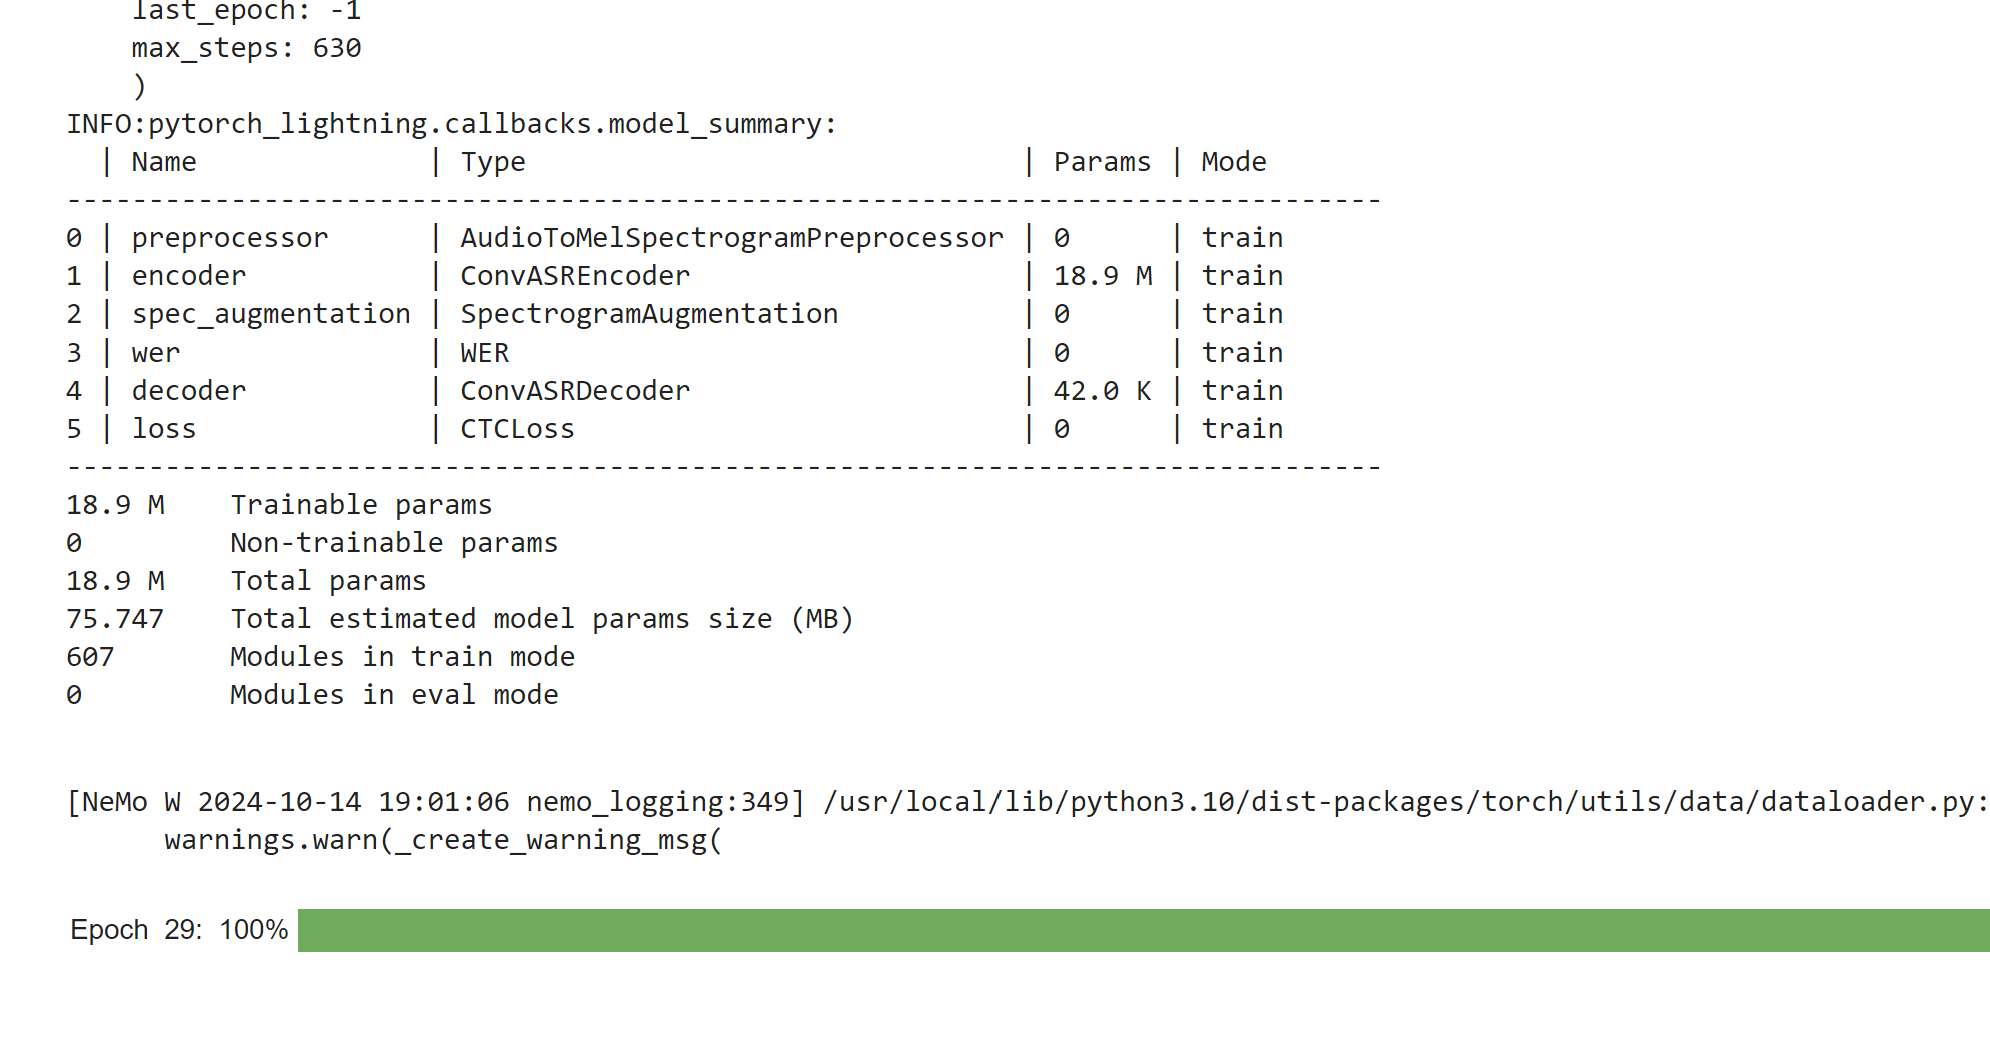